In [39]:
# read log
import os
# Get current working directory (notebook location)
base_dir = os.getcwd()

# Path to the "results" folder
results_dir = os.path.join(base_dir, 'result')

# Path to the figure output dir
figures_dir = os.path.join(base_dir, 'figure')
os.makedirs(figures_dir, exist_ok=True)

In [40]:
# process bar data
import json
from dataclasses import dataclass
result_path = os.path.join(results_dir, 'batchsize_analsis.json')
if os.path.exists(result_path):
    with open(result_path, 'r') as f:
        data = json.load(f)
        
@dataclass
class BarData:
    name: str
    batch_size: list[int]
    latencies: list[float]
    throughputs: list[float]
    
all_bar_data = []
for stage_data in [data['encode'], data['prefill'], data['decode']]:
    name = stage_data[0]['name']
    batch_size_list = []
    latency_list = []
    throughput_list = []
    for batch_size_data in stage_data:
        batch_size_list.append(batch_size_data['batch_size'])
        latency_list.append(batch_size_data['latency'])
        throughput_list.append(batch_size_data['throughput'])
        
    all_bar_data.append(BarData(
        name=name,  
        batch_size=batch_size_list, 
        latencies=latency_list, 
        throughputs=throughput_list, 
    ))

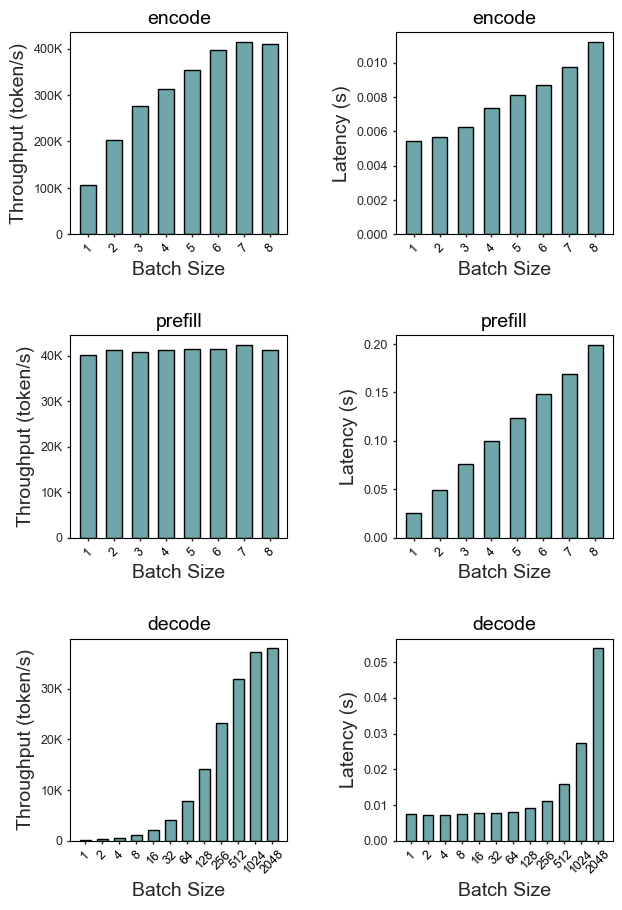

In [76]:
# visualize data and save pdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


n_rows = 3
n_cols = 2

name_id = {'encode' : 0, 'prefill' : 1, 'decode' : 2}
figsize=(3.5 * n_cols, 3.5 * n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = np.atleast_2d(axes)
plt.subplots_adjust(hspace=0.5, wspace=0.5) 

def to_k_format(x, pos):
    if x >= 1000:
        return f'{x/1000:.0f}K' if x % 1000 == 0 else f'{x/1000:.1f}K'
    return str(int(x))

fontsize=14
formatter = FuncFormatter(to_k_format)
for bar_data in all_bar_data:
    i = name_id[bar_data.name]
    n_ticks = len(bar_data.batch_size)
    x_ticks = [i for i in range(n_ticks)]
    x_ticklabels = [i for i in bar_data.batch_size]
    width=0.6
    axes[i][0].bar(x_ticks, bar_data.throughputs, width=width, color="#6EA6A9", edgecolor='black', alpha=1)
    axes[i][0].set_xlabel('Batch Size', fontsize=fontsize)
    axes[i][0].set_ylabel('Throughput (token/s)', fontsize=fontsize)
    axes[i][0].yaxis.set_major_formatter(formatter)
    
    axes[i][1].bar(x_ticks, bar_data.latencies, width=width, color="#6EA6A9", edgecolor='black', alpha=1)
    axes[i][1].set_xlabel('Batch Size', fontsize=fontsize)
    axes[i][1].set_ylabel('Latency (s)', fontsize=fontsize)
    
    for j in range(n_cols):
        axes[i][j].tick_params(axis='x', which='major', length=2, width=1, direction='out', grid_color='black', grid_alpha=1)
        axes[i][j].tick_params(axis='y', which='major', length=2, width=1, direction='out', grid_color='black', grid_alpha=1)
        axes[i][j].tick_params(which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True, direction='out')
        axes[i][j].set_title(bar_data.name, fontsize=fontsize, color='black', alpha=1)
        axes[i][j].grid(False)
        axes[i][j].set_xticks(x_ticks)
        axes[i][j].set_xticklabels(x_ticklabels, fontsize=fontsize - 5, rotation=45, color='black', alpha=1)
        for label in axes[i][j].get_yticklabels():
            label.set_fontsize(fontsize - 5)
        for spine in axes[i][j].spines.values():
            spine.set_edgecolor('black')
    
fig.savefig(os.path.join(figures_dir, "batchsize_ayalysis.pdf"), bbox_inches="tight")